In [10]:
library(data.table) 
library(ggplot2)
library(ComplexUpset)
library(repr)
library(pheatmap)
library(grid)

## Upset plot for droplet classification of genetic deconvolution methods

### Define a function to convert the result to a binary matrix 

In [2]:
convert2binary <- function(assignment, identity){
    # table in a long format
    assignment_new <- melt(assignment, id.vars=1)
    assignment_new <- na.omit(assignment_new)
 
    # Subset to identity
    assignment_new <- assignment_new[assignment_new$value==identity,]
    assignment_new <- assignment_new [, -3]

    # table in a wide format
    assignment_new <- dcast(assignment_new, Barcode~variable)
    assignment_new <- as.data.frame(lapply(assignment_new [, -1], as.numeric))

    # turn into a binary matrix
    assignment_new[!is.na(assignment_new)] <- 1
    assignment_new[is.na(assignment_new)] <- 0
    
    return(assignment_new)
}

In [3]:
# Load genetic demultiplexing results
gene_gx12_classi <-fread("../data/pipeline_output/gx12/genetic_classification_all.csv")

# Remove the trial ID
colnames(gene_gx12_classi) <- gsub("_1", "", colnames(gene_gx12_classi))

In [4]:
genetic_gx12_classi_new_singlet <- convert2binary(gene_gx12_classi, 'singlet')
genetic_gx12_classi_new_doublet <- convert2binary(gene_gx12_classi, 'doublet')

Using 'variable' as value column. Use 'value.var' to override

Using 'variable' as value column. Use 'value.var' to override



Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.
ℹ The deprecated feature was likely used in the ComplexUpset package.
  Please report the issue at
  <https://github.com/krassowski/complex-upset/issues>.”


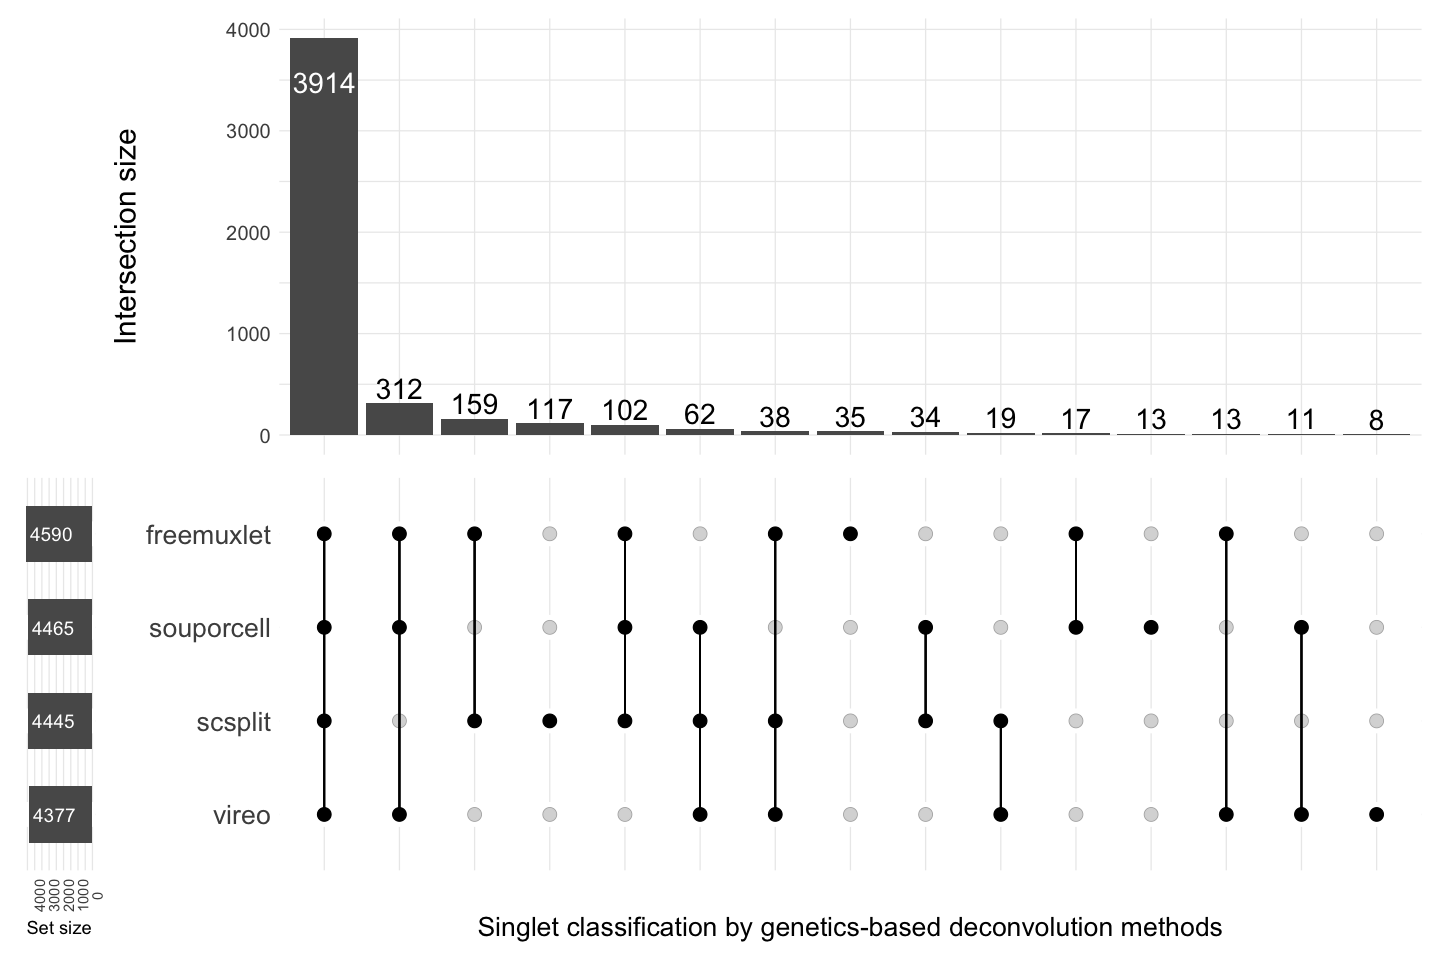

In [5]:
# Change plot size to 12 x 8
options(repr.plot.width=12, repr.plot.height=8)

ComplexUpset::upset(genetic_gx12_classi_new_singlet, colnames(genetic_gx12_classi_new_singlet), width_ratio = 0.06, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Singlet classification by genetics-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count..), hjust = -0.1, stat = 'count', color = 'white', size=4) +
                               theme(axis.text.x = element_text(angle = 90))),# set size
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=6))+
                                        theme(axis.text=element_text(size=12), axis.title=element_text(size=18))), # intersection size
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=16), #method
                                                                                text=element_text(size=16)))))# title


# ggsave("S10-upset-genetic-singlet-gx12.png", width= 12, height=8, dpi=300)

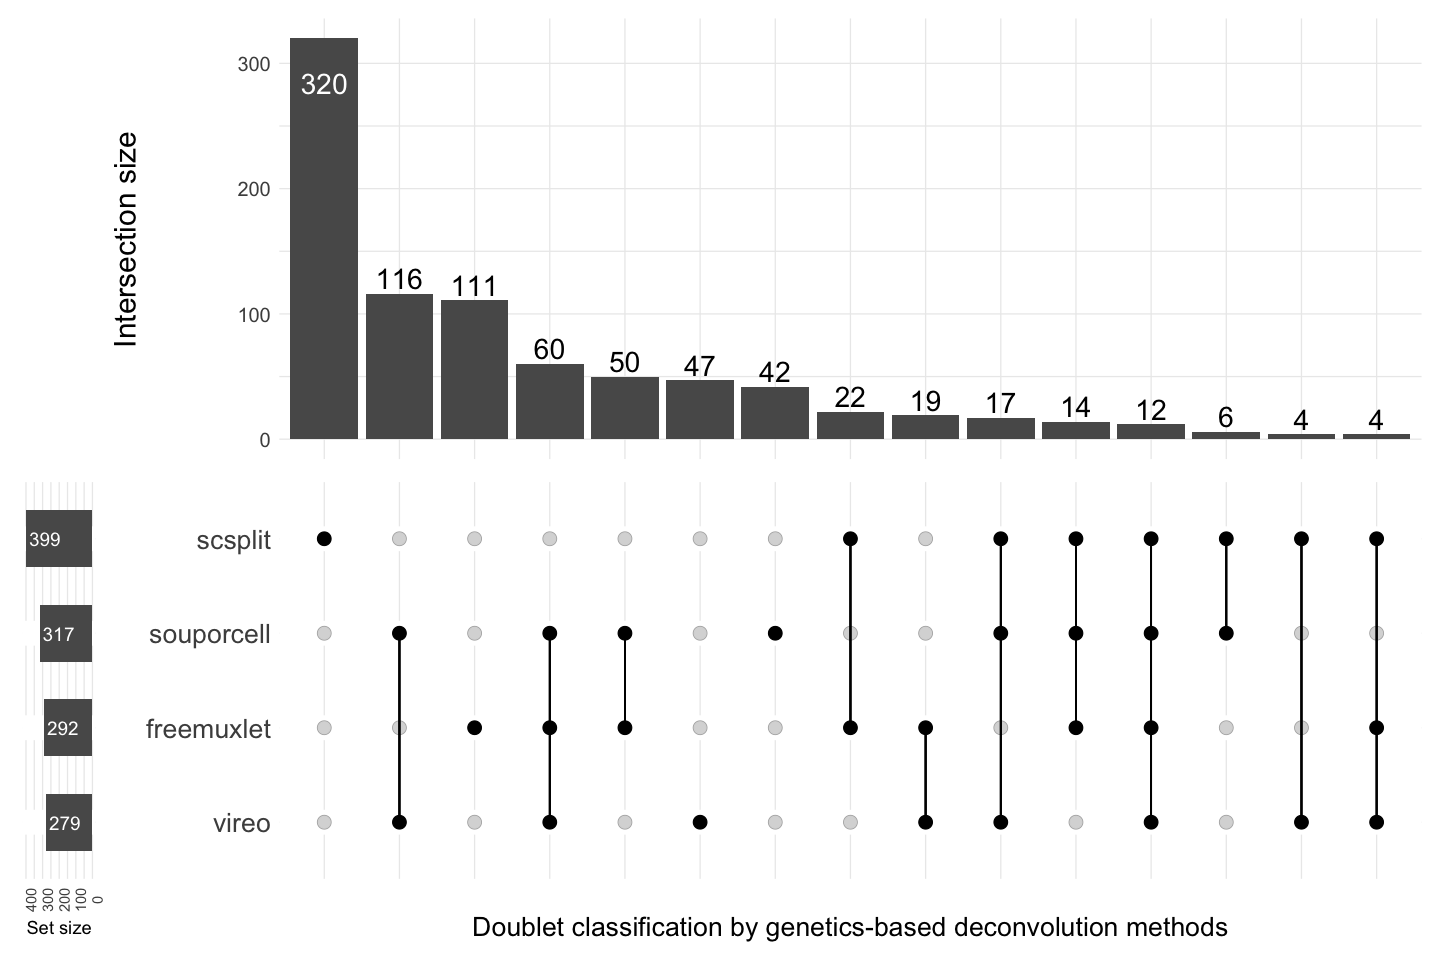

In [6]:
ComplexUpset::upset(genetic_gx12_classi_new_doublet, colnames(genetic_gx12_classi_new_doublet), width_ratio = 0.06, 
                    height_ratio = 0.9, stripes = 'white', min_degree=1, 
                    name="Doublet classification by genetics-based deconvolution methods",
                    set_sizes=(upset_set_size() + geom_text(aes(label = ..count..), hjust = -0.1, stat = 'count', color = 'white', size=4) +
                               theme(axis.text.x = element_text(angle = 90))),# set size
                    base_annotations=list('Intersection size'= intersection_size(text=list(size=6))+
                                        theme(axis.text=element_text(size=12), axis.title=element_text(size=18))), # intersection size
                    themes=upset_modify_themes(list('intersections_matrix'=theme(axis.text.y=element_text(size=16), #method
                                                                                text=element_text(size=16)))))# title


# ggsave("S11-upset-genetic-doublet-gx12.png", width= 12, height=8, dpi=300)

## Visualisation of concordance among genetic deconvolution methods through confusion matrix

In [7]:
# Load genetic demultiplexing results
gene_gx12_assign <-fread("../data/pipeline_output/gx12/genetic_assignment_all.csv")

# Remove the trial ID
colnames(gene_gx12_assign) <- gsub("_1", "", colnames(gene_gx12_assign))

# Remove the donor prefix in vireo column
gene_gx12_assign$vireo <- gsub("donor", "", gene_gx12_assign$vireo)

In [8]:
# Create an empyt matrix
confusion_matrix_f_so = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_f_so) = 0:5
colnames(confusion_matrix_f_so) = 0:5

# Fill the matrix
for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx12_assign[gene_gx12_assign$freemuxlet == i & gene_gx12_assign$souporcell == j,])
    confusion_matrix_f_so[i+1,j+1] = row
  }
}

confusion_matrix_f_so

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,0,646,1,0,0,0
1,756,0,0,1,0,0
2,1,0,697,0,0,1
3,0,1,0,223,1,0
4,0,0,0,0,0,795
5,0,0,0,1,1220,1


,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,747,0,0,0,0,0
1,0,0,0,631,0,0
2,0,0,0,1,0,701
3,0,0,1,0,227,0
4,0,1194,0,0,0,0
5,0,0,795,1,0,1


pdf 
  3

pdf 
  2

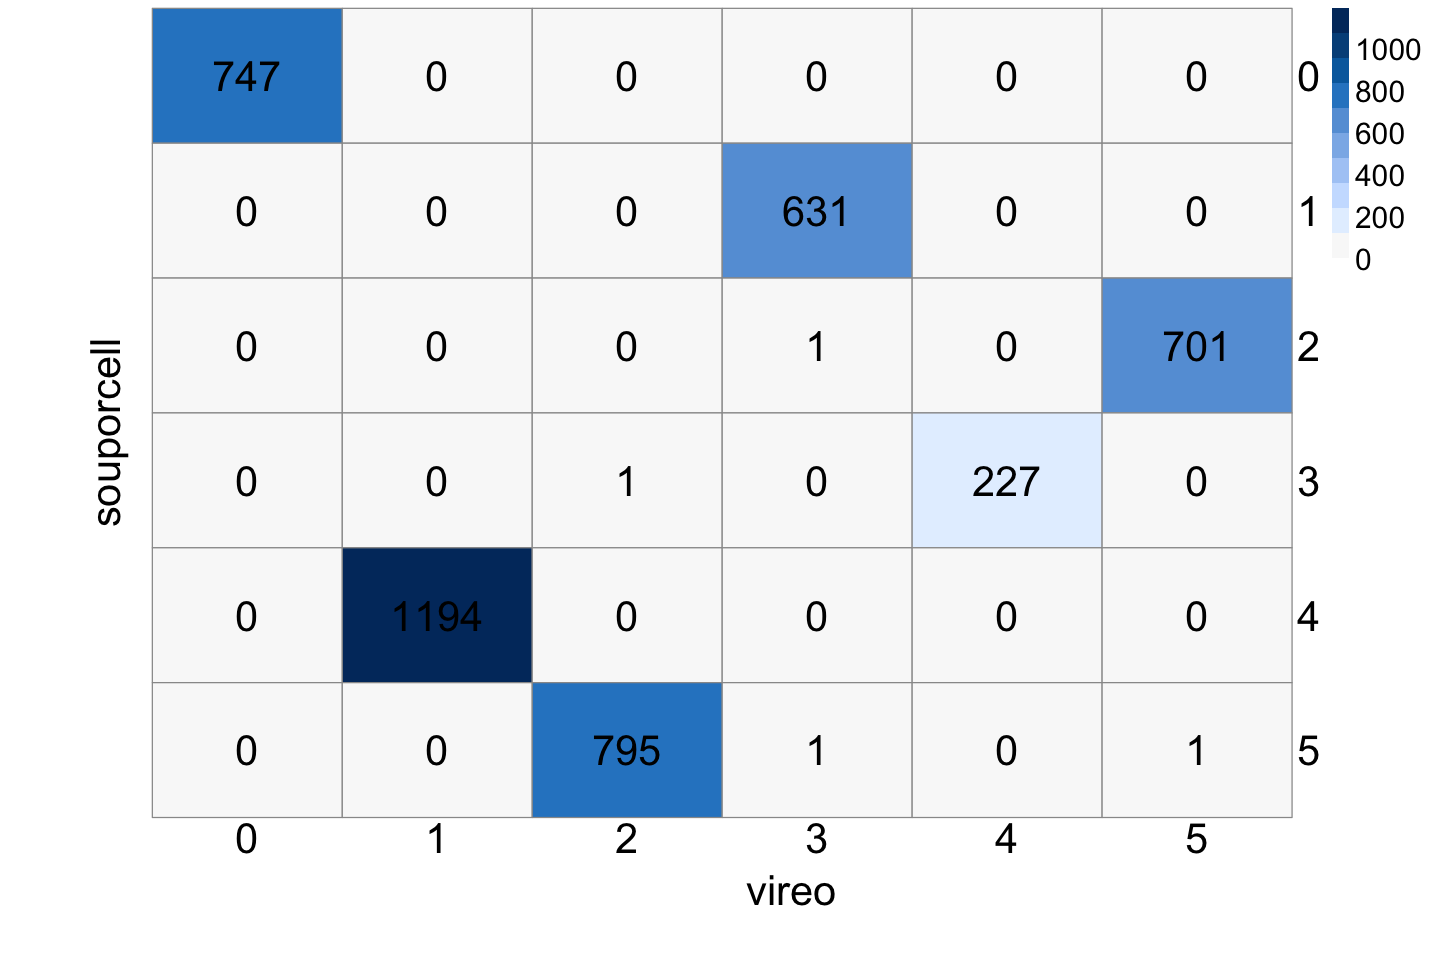

In [13]:
# Create an empyt matrix
confusion_matrix_v_so = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_so) = 0:5
colnames(confusion_matrix_v_so) = 0:5

# Fill the matrix
for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx12_assign[gene_gx12_assign$souporcell == i & gene_gx12_assign$vireo == j,])
    confusion_matrix_v_so[i+1,j+1] = row
  }
}

confusion_matrix_v_so

pdf("S12-heatmap-so-v-gx12.pdf", width=11, height=11)
# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_so, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("souporcell", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,1,0,1,630,0,0
1,749,0,0,0,0,0
2,0,0,0,1,1,688
3,0,0,0,0,229,0
4,0,0,780,0,0,0
5,0,1196,0,1,0,0


pdf 
  3

pdf 
  2

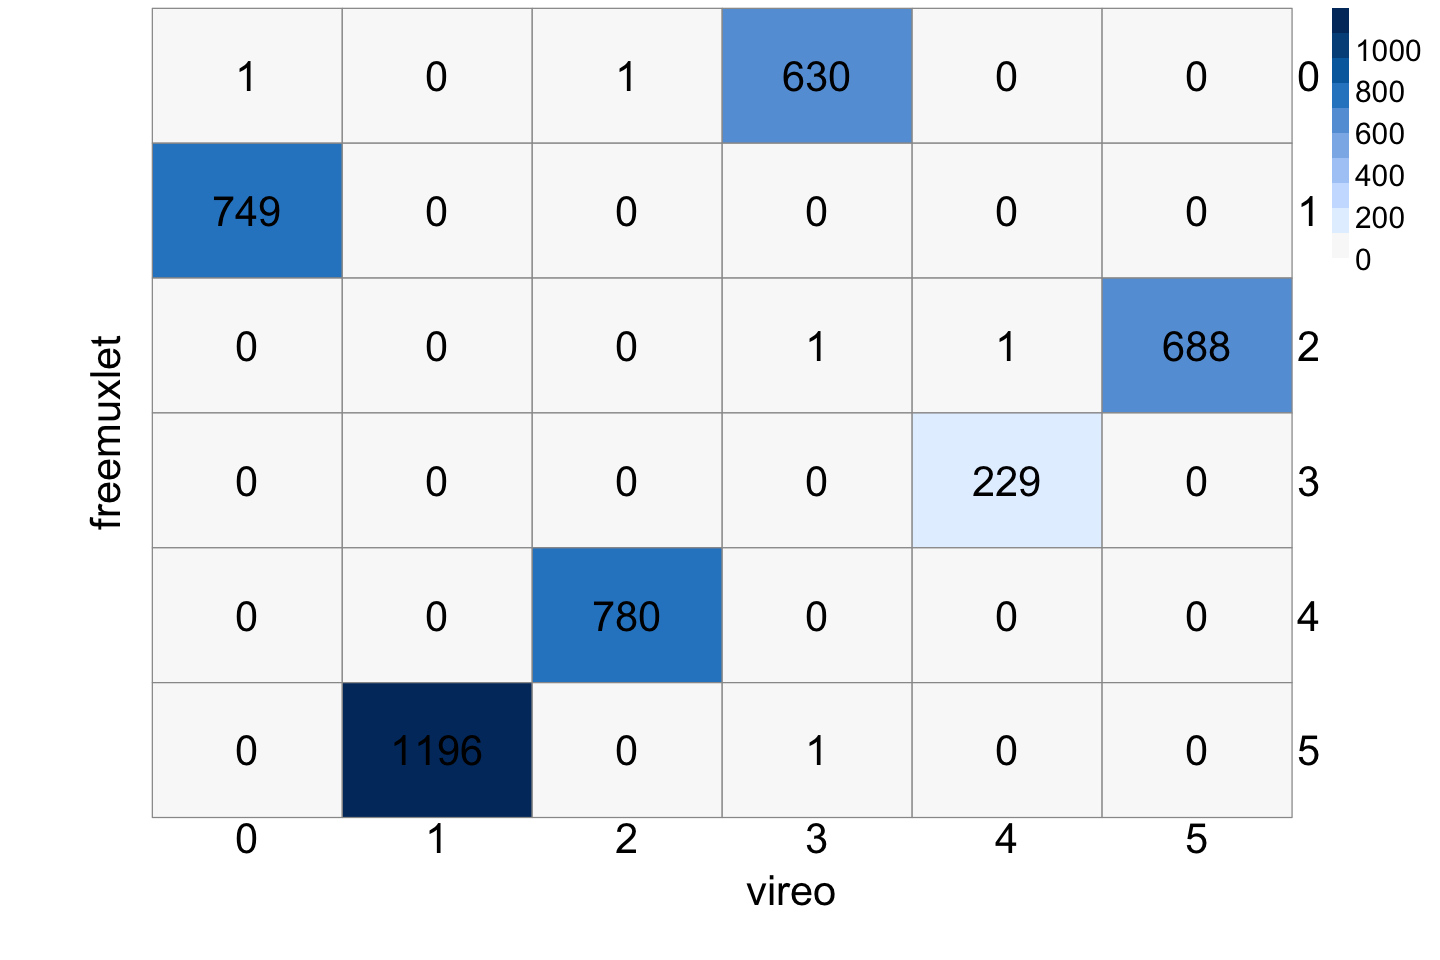

In [14]:
# Create an empyt matrix
confusion_matrix_v_fr = as.data.frame(matrix(ncol = 6, nrow = 6))
rownames(confusion_matrix_v_fr) = 0:5
colnames(confusion_matrix_v_fr) = 0:5

# Fill the matrix
for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx12_assign[gene_gx12_assign$freemuxlet == i & gene_gx12_assign$vireo == j,])
    confusion_matrix_v_fr[i+1,j+1] = row
  }
}

confusion_matrix_v_fr

pdf("S13-heatmap-fr-v-gx12.pdf", width=11, height=11)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_fr, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("freemuxlet", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()

,0,1,2,3,4,5
,<int>,<int>,<int>,<int>,<int>,<int>
0,9,14,15,3,18,511
1,8,7,653,16,16,3
2,1,0,3,591,0,3
3,717,26,7,1,21,2
5,8,33,64,4,106,163
6,1,968,6,7,26,2


pdf 
  3

pdf 
  2

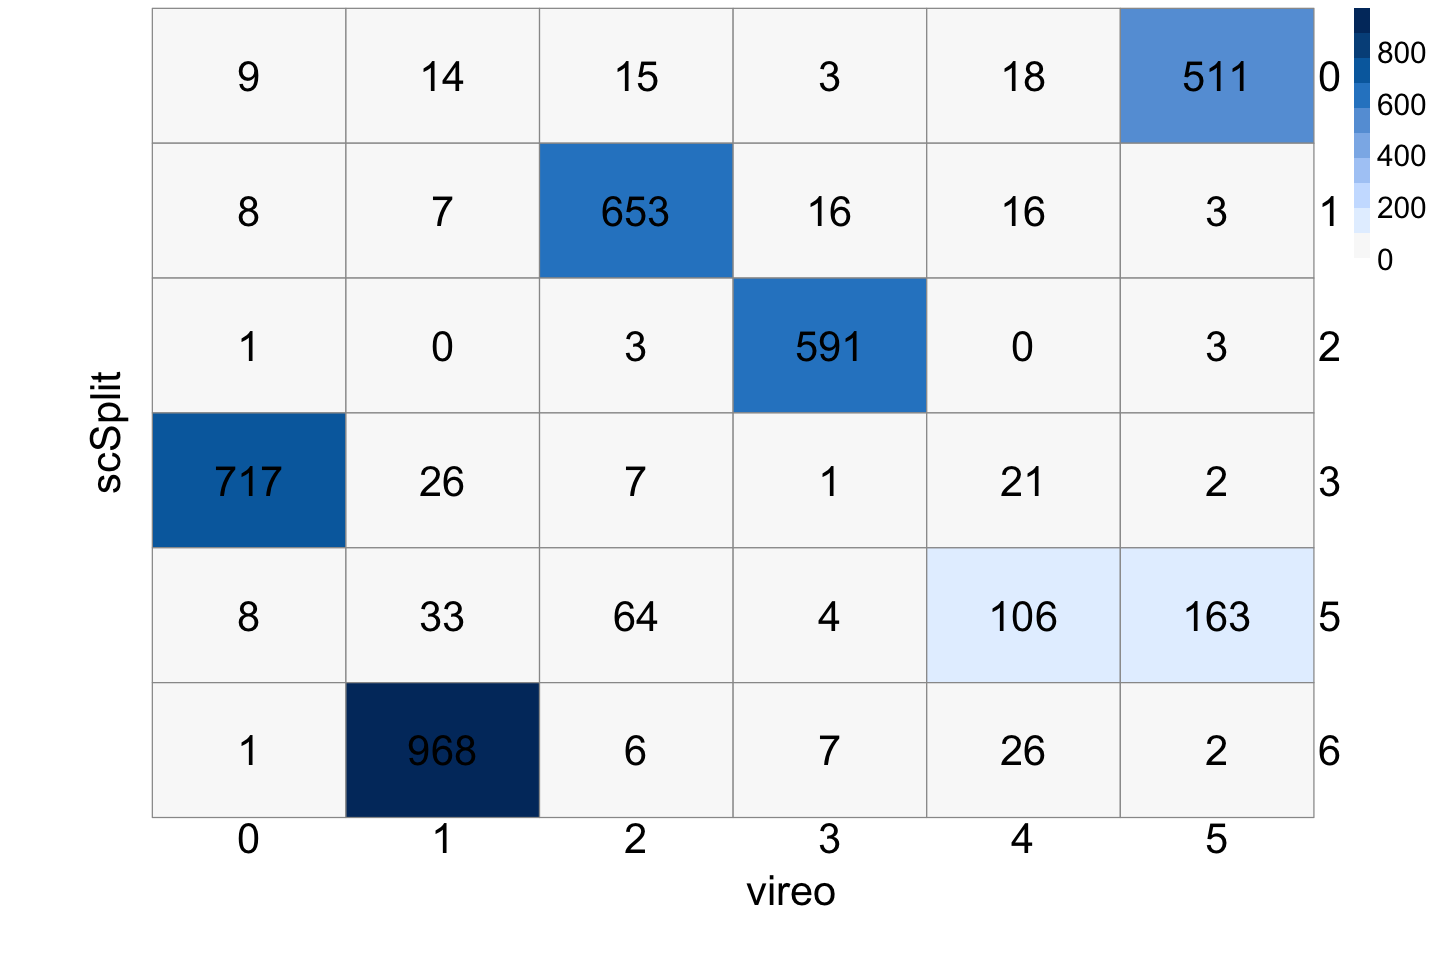

In [15]:
# Create an empyt matrix
confusion_matrix_v_sc = as.data.frame(matrix(ncol = 6, nrow = 6))
colnames(confusion_matrix_v_sc) = 0:5

# scSplit assigned doublets to cluster 4
donor_list <- c(0:3, 5:6)
rownames(confusion_matrix_v_sc) = donor_list

for (i in c(0:5)){
  for (j in c(0:5)){
    row = nrow(gene_gx12_assign[gene_gx12_assign$vireo == j & 
                                gene_gx12_assign$scsplit == donor_list[i+1],])
    confusion_matrix_v_sc[i+1,j+1] = row
  }
}

confusion_matrix_v_sc

pdf("S14-heatmap-v-sc-gx12.pdf", width=11, height=11)

# Add axis title
setHook("grid.newpage", function() 
    pushViewport(viewport(x=1,y=1,width=0.9, height=0.9, name="vp", just=c("right","top"))), action="prepend")

pheatmap(confusion_matrix_v_sc, treeheight_row=F, treeheight_col=F, display_numbers=T, angle_col="0",
         number_color = "black", fontsize_number= 25, fontsize = 18, fontsize_row = 25, fontsize_col = 25, cluster_rows = F, cluster_cols = F, number_format = "%.f",
         color = hcl.colors(10, "Blues 3", rev= T))

setHook("grid.newpage", NULL, "replace")
grid.text("vireo", y=-0.03, gp=gpar(fontsize=25))
grid.text("scSplit", x=-0.03, rot=90, gp=gpar(fontsize=25))
        
dev.copy()
dev.off()